In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [4]:
data_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/data/processed/multimodal_unaligned_data.pkl')
with open(data_path, 'rb') as f:
    data = pickle.load(f)

traj_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/results/dual_encoder_model/latent_trajectories.pkl')
with open(traj_path, 'rb') as f:
    trajectories = pickle.load(f)

patients = data['patients']
train_traj = trajectories['train']
val_traj = trajectories['val']
test_traj = trajectories['test']

print(f"Loaded {len(train_traj)} train, {len(val_traj)} val, {len(test_traj)} test trajectories")

Loaded 70 train, 15 val, 15 test trajectories


## compute trajectory features

In [5]:
def compute_trajectory_features(traj_dict):
    features = {}
    
    for patient_id, traj_data in traj_dict.items():
        timepoints = traj_data['timepoints']
        latent_traj = traj_data['latent_trajectory']
        
        if len(latent_traj) < 2:
            continue
        
        velocity = np.linalg.norm(np.gradient(latent_traj, axis=0), axis=1)
        displacement = np.linalg.norm(latent_traj[-1] - latent_traj[0])
        path_length = np.sum(np.linalg.norm(np.diff(latent_traj, axis=0), axis=1))
        directionality = displacement / (path_length + 1e-6)
        
        features[patient_id] = {
            'timepoints': timepoints,
            'velocity_magnitude': velocity,
            'mean_velocity': np.mean(velocity),
            'displacement': displacement,
            'directionality': directionality,
            'diagnosis': traj_data['diagnosis']
        }
    
    return features

train_features = compute_trajectory_features(train_traj)
val_features = compute_trajectory_features(val_traj)
test_features = compute_trajectory_features(test_traj)

print(f"Features computed: {len(train_features)} train, {len(val_features)} val, {len(test_features)} test")

Features computed: 70 train, 15 val, 15 test


## clinical score validation

In [6]:
def validate_against_clinical_scores(features_dict, patient_dict):
    results = {}
    
    for patient_id, features in features_dict.items():
        if patient_id not in patient_dict:
            continue
        
        patient_data = patient_dict[patient_id]
        diagnosis = patient_data['diagnosis']
        
        if diagnosis not in results:
            results[diagnosis] = []
        
        disease_scores = patient_data['mgx']['disease_activity']
        score_times = patient_data['mgx']['timepoints']
        
        traj_times = features['timepoints']
        velocity = features['velocity_magnitude']
        
        valid_mask = ~np.isnan(disease_scores)
        if valid_mask.sum() < 3:
            continue
        
        score_times_valid = score_times[valid_mask]
        disease_scores_valid = disease_scores[valid_mask]
        
        velocity_at_scores = []
        for t in score_times_valid:
            idx = np.argmin(np.abs(traj_times - t))
            velocity_at_scores.append(velocity[idx])
        
        results[diagnosis].append({
            'patient_id': patient_id,
            'velocity': np.array(velocity_at_scores),
            'disease_score': disease_scores_valid
        })
    
    return results

train_val_features = {**train_features, **val_features}
train_val_results = validate_against_clinical_scores(train_val_features, patients)
test_results = validate_against_clinical_scores(test_features, patients)

print(f"Clinical validation prepared")
for diag in train_val_results:
    print(f"  {diag}: {len(train_val_results[diag])} patients (train+val)")

Clinical validation prepared
  CD: 40 patients (train+val)
  UC: 22 patients (train+val)
  nonIBD: 0 patients (train+val)


In [7]:
def compute_correlations(results_dict):
    correlations = {}
    
    for diagnosis in results_dict:
        if len(results_dict[diagnosis]) == 0:
            continue
        
        all_velocity = np.concatenate([r['velocity'] for r in results_dict[diagnosis]])
        all_scores = np.concatenate([r['disease_score'] for r in results_dict[diagnosis]])
        
        r_pearson, p_pearson = pearsonr(all_velocity, all_scores)
        r_spearman, p_spearman = spearmanr(all_velocity, all_scores)
        
        correlations[diagnosis] = {
            'pearson_r': r_pearson,
            'pearson_p': p_pearson,
            'spearman_r': r_spearman,
            'spearman_p': p_spearman,
            'n_samples': len(all_velocity),
            'n_patients': len(results_dict[diagnosis])
        }
    
    return correlations

train_val_corr = compute_correlations(train_val_results)
test_corr = compute_correlations(test_results)

print("\n" + "="*70)
print("CLINICAL VALIDATION: Trajectory Velocity vs Disease Scores")
print("="*70)

print("\nTrain+Val:")
for diagnosis in ['CD', 'UC']:
    if diagnosis in train_val_corr:
        c = train_val_corr[diagnosis]
        score_name = 'HBI' if diagnosis == 'CD' else 'SCCAI'
        print(f"\n{diagnosis} ({score_name}):")
        print(f"  Pearson r = {c['pearson_r']:.3f}, p = {c['pearson_p']:.4f}")
        print(f"  Spearman ρ = {c['spearman_r']:.3f}, p = {c['spearman_p']:.4f}")
        print(f"  N = {c['n_samples']} observations, {c['n_patients']} patients")

print("\n\nTest:")
for diagnosis in ['CD', 'UC']:
    if diagnosis in test_corr:
        c = test_corr[diagnosis]
        score_name = 'HBI' if diagnosis == 'CD' else 'SCCAI'
        print(f"\n{diagnosis} ({score_name}):")
        print(f"  Pearson r = {c['pearson_r']:.3f}, p = {c['pearson_p']:.4f}")
        print(f"  Spearman ρ = {c['spearman_r']:.3f}, p = {c['spearman_p']:.4f}")
        print(f"  N = {c['n_samples']} observations, {c['n_patients']} patients")


CLINICAL VALIDATION: Trajectory Velocity vs Disease Scores

Train+Val:

CD (HBI):
  Pearson r = 0.147, p = 0.0006
  Spearman ρ = 0.076, p = 0.0769
  N = 539 observations, 40 patients

UC (SCCAI):
  Pearson r = 0.247, p = 0.0000
  Spearman ρ = 0.112, p = 0.0450
  N = 319 observations, 22 patients


Test:

CD (HBI):
  Pearson r = -0.002, p = 0.9845
  Spearman ρ = -0.134, p = 0.1729
  N = 105 observations, 7 patients

UC (SCCAI):
  Pearson r = 0.259, p = 0.0442
  Spearman ρ = 0.117, p = 0.3696
  N = 61 observations, 4 patients


## MTX validation

In [8]:
def compute_mtx_inflammatory_signal(mtx_coords):
    """MTX inflammatory signal = magnitude of MTX PCA vector."""
    inflammatory_signal = np.linalg.norm(mtx_coords, axis=1)
    return inflammatory_signal

def validate_against_mtx(features_dict, patient_dict):
    results = {}
    
    for patient_id, features in features_dict.items():
        if patient_id not in patient_dict:
            continue
        
        patient_data = patient_dict[patient_id]
        diagnosis = patient_data['diagnosis']
        
        if diagnosis not in results:
            results[diagnosis] = []
        
        mtx_coords = patient_data['mtx']['pca_coords']
        mtx_times = patient_data['mtx']['timepoints']
        
        mtx_signal = compute_mtx_inflammatory_signal(mtx_coords)
        
        traj_times = features['timepoints']
        velocity = features['velocity_magnitude']
        
        velocity_at_mtx = []
        for t in mtx_times:
            idx = np.argmin(np.abs(traj_times - t))
            velocity_at_mtx.append(velocity[idx])
        
        results[diagnosis].append({
            'patient_id': patient_id,
            'velocity': np.array(velocity_at_mtx),
            'mtx_signal': mtx_signal
        })
    
    return results

train_val_mtx = validate_against_mtx(train_val_features, patients)
test_mtx = validate_against_mtx(test_features, patients)

print("MTX validation prepared")
for diag in train_val_mtx:
    print(f"  {diag}: {len(train_val_mtx[diag])} patients (train+val)")

MTX validation prepared
  CD: 41 patients (train+val)
  UC: 22 patients (train+val)
  nonIBD: 22 patients (train+val)


In [9]:
def compute_mtx_correlations(results_dict):
    correlations = {}
    
    for diagnosis in results_dict:
        if len(results_dict[diagnosis]) == 0:
            continue
        
        all_velocity = np.concatenate([r['velocity'] for r in results_dict[diagnosis]])
        all_mtx = np.concatenate([r['mtx_signal'] for r in results_dict[diagnosis]])
        
        r_pearson, p_pearson = pearsonr(all_velocity, all_mtx)
        r_spearman, p_spearman = spearmanr(all_velocity, all_mtx)
        
        correlations[diagnosis] = {
            'pearson_r': r_pearson,
            'pearson_p': p_pearson,
            'spearman_r': r_spearman,
            'spearman_p': p_spearman,
            'n_samples': len(all_velocity),
            'n_patients': len(results_dict[diagnosis])
        }
    
    return correlations

train_val_mtx_corr = compute_mtx_correlations(train_val_mtx)
test_mtx_corr = compute_mtx_correlations(test_mtx)

print("\n" + "="*70)
print("MTX VALIDATION: Trajectory Velocity vs MTX Inflammatory Signal")
print("="*70)

print("\nTrain+Val:")
for diagnosis in ['CD', 'UC']:
    if diagnosis in train_val_mtx_corr:
        c = train_val_mtx_corr[diagnosis]
        print(f"\n{diagnosis}:")
        print(f"  Pearson r = {c['pearson_r']:.3f}, p = {c['pearson_p']:.4f}")
        print(f"  Spearman ρ = {c['spearman_r']:.3f}, p = {c['spearman_p']:.4f}")
        print(f"  N = {c['n_samples']} observations, {c['n_patients']} patients")

print("\n\nTest:")
for diagnosis in ['CD', 'UC']:
    if diagnosis in test_mtx_corr:
        c = test_mtx_corr[diagnosis]
        print(f"\n{diagnosis}:")
        print(f"  Pearson r = {c['pearson_r']:.3f}, p = {c['pearson_p']:.4f}")
        print(f"  Spearman ρ = {c['spearman_r']:.3f}, p = {c['spearman_p']:.4f}")
        print(f"  N = {c['n_samples']} observations, {c['n_patients']} patients")


MTX VALIDATION: Trajectory Velocity vs MTX Inflammatory Signal

Train+Val:

CD:
  Pearson r = 0.157, p = 0.0089
  Spearman ρ = -0.019, p = 0.7561
  N = 276 observations, 41 patients

UC:
  Pearson r = 0.275, p = 0.0002
  Spearman ρ = 0.119, p = 0.1164
  N = 174 observations, 22 patients


Test:

CD:
  Pearson r = 0.070, p = 0.5973
  Spearman ρ = -0.121, p = 0.3587
  N = 60 observations, 7 patients

UC:
  Pearson r = 0.053, p = 0.7736
  Spearman ρ = -0.250, p = 0.1670
  N = 32 observations, 4 patients


## comparative summary

In [10]:
print("\n" + "="*70)
print("COMPARISON: Clinical Scores vs MTX Molecular Signal")
print("="*70)

for diagnosis in ['CD', 'UC']:
    if diagnosis not in train_val_corr or diagnosis not in train_val_mtx_corr:
        continue
    
    clinical = train_val_corr[diagnosis]
    mtx = train_val_mtx_corr[diagnosis]
    
    score_name = 'HBI' if diagnosis == 'CD' else 'SCCAI'
    
    print(f"\n{diagnosis}:")
    print(f"  {score_name} (clinical):        r = {clinical['pearson_r']:.3f}, p = {clinical['pearson_p']:.4f}")
    print(f"  MTX inflammatory signal: r = {mtx['pearson_r']:.3f}, p = {mtx['pearson_p']:.4f}")
    
    improvement = mtx['pearson_r'] - clinical['pearson_r']
    print(f"  MTX improvement:         Δr = {improvement:+.3f}")
    
    if mtx['pearson_r'] > clinical['pearson_r']:
        print(f"  → MTX validation is STRONGER ✓")
    else:
        print(f"  → Clinical scores remain stronger")


COMPARISON: Clinical Scores vs MTX Molecular Signal

CD:
  HBI (clinical):        r = 0.147, p = 0.0006
  MTX inflammatory signal: r = 0.157, p = 0.0089
  MTX improvement:         Δr = +0.011
  → MTX validation is STRONGER ✓

UC:
  SCCAI (clinical):        r = 0.247, p = 0.0000
  MTX inflammatory signal: r = 0.275, p = 0.0002
  MTX improvement:         Δr = +0.028
  → MTX validation is STRONGER ✓


## visualizations

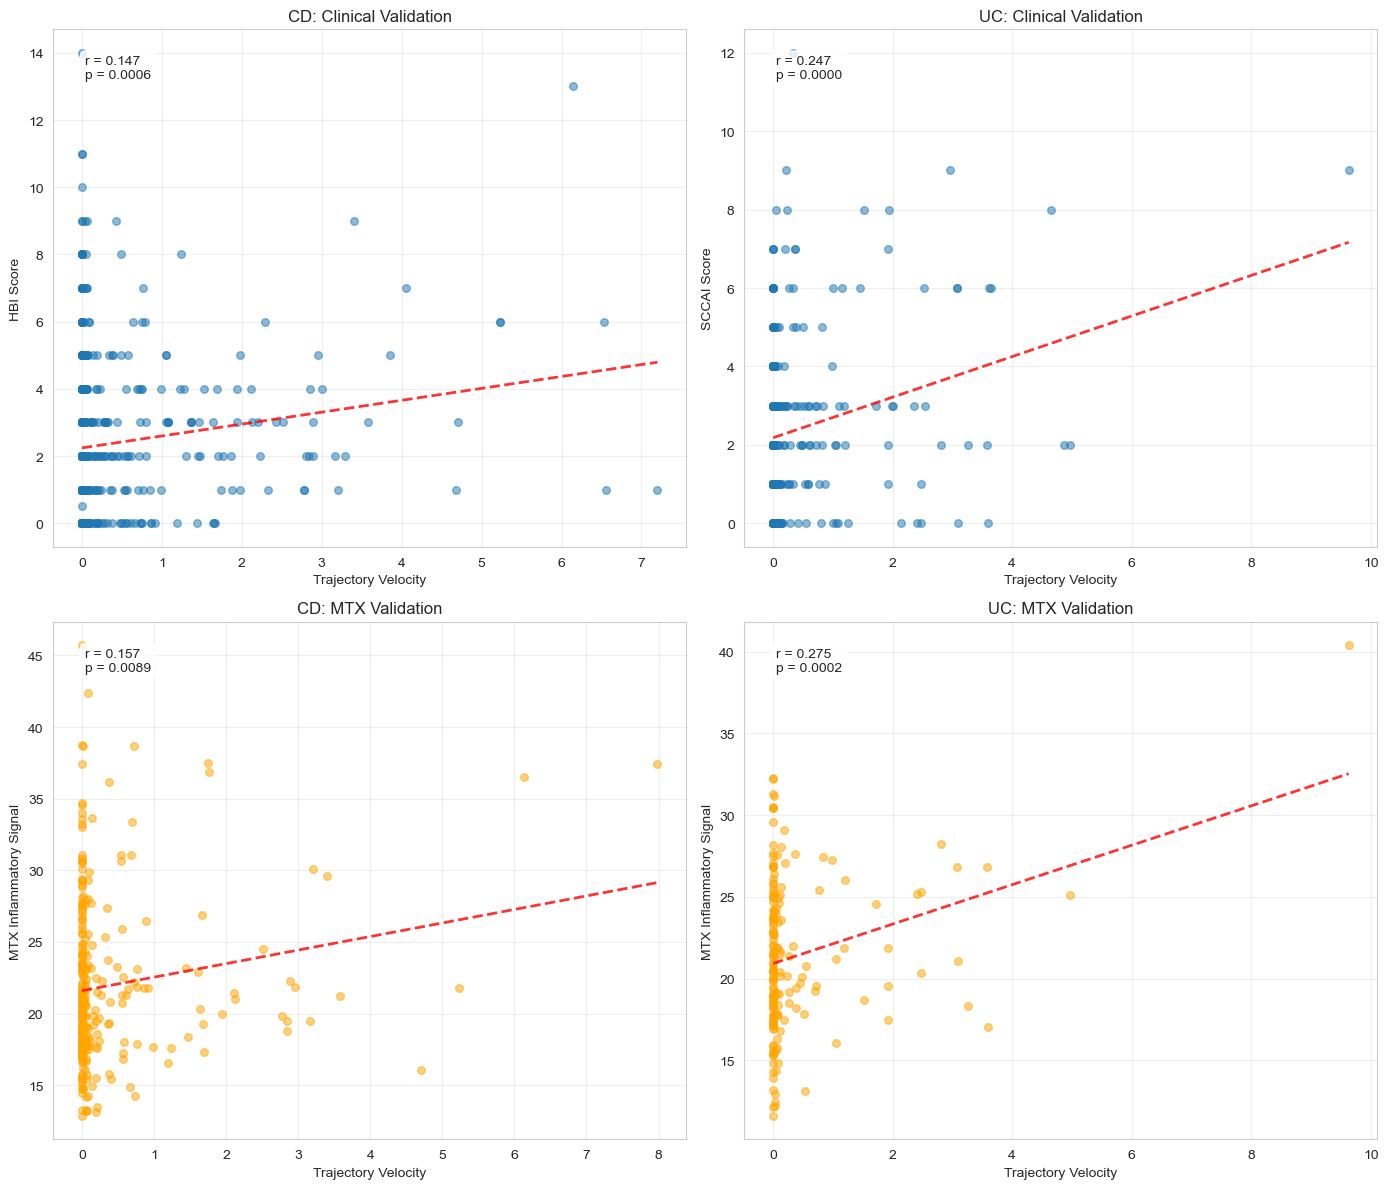

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Row 1: Clinical validation
for idx, diagnosis in enumerate(['CD', 'UC']):
    ax = axes[0, idx]
    
    if diagnosis not in train_val_results or len(train_val_results[diagnosis]) == 0:
        ax.text(0.5, 0.5, f'No data for {diagnosis}', ha='center', va='center', transform=ax.transAxes)
        continue
    
    velocity = np.concatenate([r['velocity'] for r in train_val_results[diagnosis]])
    scores = np.concatenate([r['disease_score'] for r in train_val_results[diagnosis]])
    
    ax.scatter(velocity, scores, alpha=0.5, s=30)
    
    z = np.polyfit(velocity, scores, 1)
    p = np.poly1d(z)
    x_line = np.linspace(velocity.min(), velocity.max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8)
    
    r, pval = pearsonr(velocity, scores)
    score_name = 'HBI' if diagnosis == 'CD' else 'SCCAI'
    
    ax.text(0.05, 0.95, f'r = {r:.3f}\np = {pval:.4f}', transform=ax.transAxes,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Trajectory Velocity')
    ax.set_ylabel(f'{score_name} Score')
    ax.set_title(f'{diagnosis}: Clinical Validation')
    ax.grid(alpha=0.3)

# Row 2: MTX validation
for idx, diagnosis in enumerate(['CD', 'UC']):
    ax = axes[1, idx]
    
    if diagnosis not in train_val_mtx or len(train_val_mtx[diagnosis]) == 0:
        ax.text(0.5, 0.5, f'No data for {diagnosis}', ha='center', va='center', transform=ax.transAxes)
        continue
    
    velocity = np.concatenate([r['velocity'] for r in train_val_mtx[diagnosis]])
    mtx_signal = np.concatenate([r['mtx_signal'] for r in train_val_mtx[diagnosis]])
    
    ax.scatter(velocity, mtx_signal, alpha=0.5, s=30, color='orange')
    
    z = np.polyfit(velocity, mtx_signal, 1)
    p = np.poly1d(z)
    x_line = np.linspace(velocity.min(), velocity.max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8)
    
    r, pval = pearsonr(velocity, mtx_signal)
    
    ax.text(0.05, 0.95, f'r = {r:.3f}\np = {pval:.4f}', transform=ax.transAxes,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Trajectory Velocity')
    ax.set_ylabel('MTX Inflammatory Signal')
    ax.set_title(f'{diagnosis}: MTX Validation')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/dual_encoder_model/validation_comparison.png', dpi=150)
plt.show()